In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
from typing import List
import torch
import glob
import random
import re
from itertools import product
import torchvision.transforms as tv
from torch.utils.data import WeightedRandomSampler
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class GaussianNoise:
    def __init__(self, mean:float=0., std:float=1.):
        """
        Add Gaussian noise to the PyTorch tensor representation of images
        Args:
            - mean - the mean of random normal distribution
            - std - standard deviation
        """
        self.mean = mean
        self.std = std

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor + torch.randn(tensor.shape)*self.std + self.mean

    def __repr__(self) -> str:
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [136]:
class CustomDataset(Dataset):
    def __init__(self, imageFolderDirs:List[str], regex:str="1\d{2}", aug_regex:str='', in_hw:int=100, transform=None, valid:bool=False):
        """
        Custom fingerprint dataset, randomly creates a pair of images for each image in self.data.
        We set the probability of pair from the same class to be 1/4 and 3/4 for different class, so that the dataset 
        is only slightly imbalanced. It is later on benefficial to the database check in authorization process.
        
        Args:
            - imageFolderDirs - a list of folder directories with selected images
            - regex - defines which 100 images will be considered (e.g. from 100 to 199 for regex "1\d{2}")
            - aug_regex - which augmentation to include, if not specified, all augmentations are taken into account (if present in the directory)
            - in_hw - input height and width of the images (used in Resize method)
            - transform - torchvision transformations to be applied on the images (augmentation)
            - valid - for validation dataset we want the transformations to be applied to the original data and saved in self.data
        """
        self.transform = transform
        self.valid = valid
        self.imageFolderDirs = imageFolderDirs
        self.in_hw = in_hw
        self.regex = regex
        self.aug_regex = aug_regex
        self.data = self.get_data()
        
        
    def get_data(self):
        data = []
        for path in self.imageFolderDirs:
            for filename in glob.glob(path+'/*_Left_thumb_finger*'+self.aug_regex):
                label = re.findall(self.regex, filename)
                if label:  
                    label = int(label[0])
                else:
                    continue
                img = Image.open(filename).convert('L')
                img = tv.ToTensor()(tv.Resize([self.in_hw, self.in_hw]) (img))
                if self.transform is not None and self.valid:
                    img = self.transform(img)  # apply specified transformations
                data.append((img, label))
        return data
        
    
    def __getitem__(self, index):
        
        img1_tuple = random.choice(self.data)
        same_class = random.choice([0,0,0,0,0,1])  # choose the same class with prob 1/6 and a different class with probability 5/6
        if same_class:
            while True:
                img2_tuple = random.choice(self.data)
                if img1_tuple[1] == img2_tuple[1]:
                    break
        else:
            while True:
                img2_tuple = random.choice(self.data)
                if img1_tuple[1] != img2_tuple[1]:
                    break
        
        img1 = img1_tuple[0]
        img2 = img2_tuple[0]
        
        if self.transform is not None and not self.valid:  # additional data augmentation
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img1, img2, torch.from_numpy(np.array([int(img1_tuple[1] != img2_tuple[1])], dtype=np.float32))
    
    
    def __len__(self):
        return len(self.data)

## $Loss = \sum_{k=1}^{128}\left(1-Y\right)\frac{1}{2}(D_k)^2 + Y\frac{1}{2} \{max(0, margin-D_k)\}^2 $

In [137]:
class ContrastiveLoss(nn.Module):
    
    def __init__(self, margin:float=2.0):
        """
        Args:
          margin - float, the greater its value, the further representations matter for the error

        We will be using euclidean distance to compute the distance between each pair of embeddings.
        """
        super().__init__()
        self.margin = margin


    def forward(self, output1, output2, label):
        E_dist = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label)*torch.pow(E_dist, 2) + label*torch.pow(torch.clamp(self.margin-E_dist, min=0.0), 2))
        
        return loss_contrastive

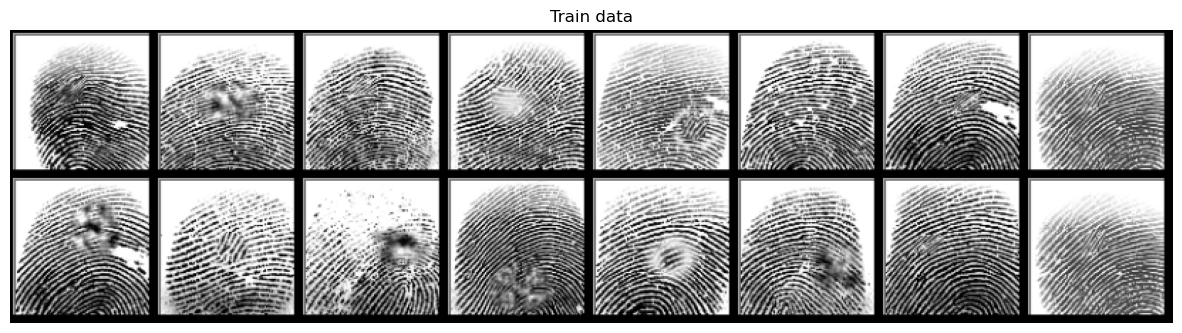

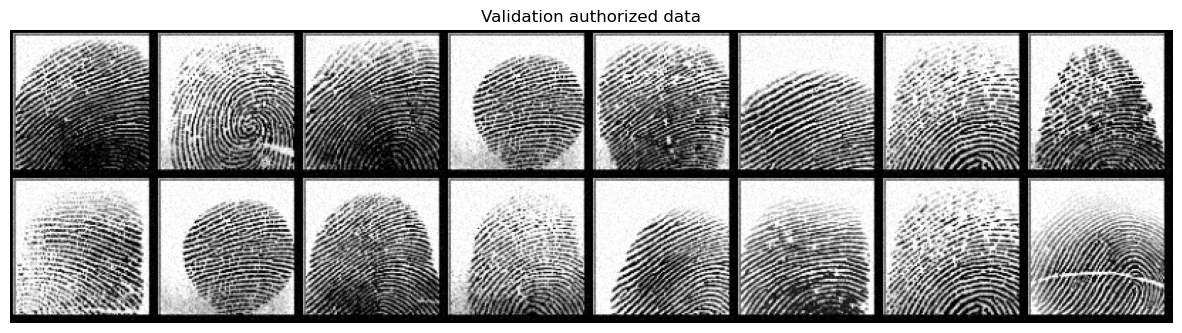

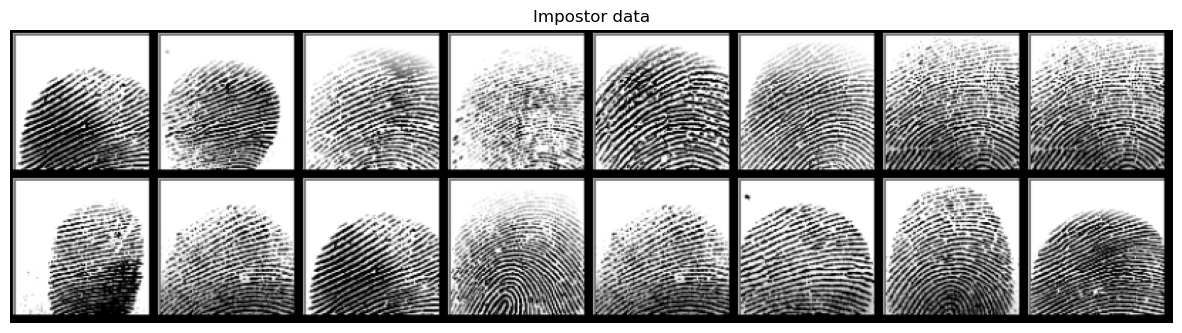

In [186]:
def imshow(img, text:str='Train data'):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.title(text)
    plt.show()


def create_test_dl(train_data:List, test_data:List, transform:bool=False) -> DataLoader:
    batch_size = len(train_data) # load all comparisons in one batch, for each test fingerprint
    pairs_test = []
    for img1 in test_data:  # for each impostor (or authorized person) check the whole database
        for img2 in train_data:
            if transform:
                transforms = tv.Compose([
                    GaussianNoise(0, 0.03),
                    tv.RandomRotation(degrees=(-4,4))
                ])
                img_pair = (transforms(img1[0]), img2[0])  # add Blur, Rotation and Gaussian Noise to the test image
            else:
                img_pair = (img1[0], img2[0])
            pairs_test.append((img_pair, int(img1[1]!=img2[1])))
    return DataLoader(pairs_test, batch_size=batch_size, num_workers=2, shuffle=False)


transforms = GaussianNoise(0, 0.04)
train_dataset = CustomDataset(['/kaggle/input/socofing/SOCOFing/Real', '/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy'], in_hw=100)
authorized_dataset = CustomDataset(['/kaggle/input/socofing/SOCOFing/Real'], in_hw=100, transform=transforms, valid=True)
impostors_dataset = CustomDataset(['/kaggle/input/socofing/SOCOFing/Real'], in_hw=100, regex='5\d{2}')

for dataset, title in zip([train_dataset, authorized_dataset, impostors_dataset], ['Train data', 'Validation authorized data', 'Impostor data']):
    vis_dl = DataLoader(dataset, batch_size=8, shuffle=True)
    example = next(iter(vis_dl))
    concatenated = torch.cat((example[0], example[1]),0)
    imshow(torchvision.utils.make_grid(concatenated), text=title)

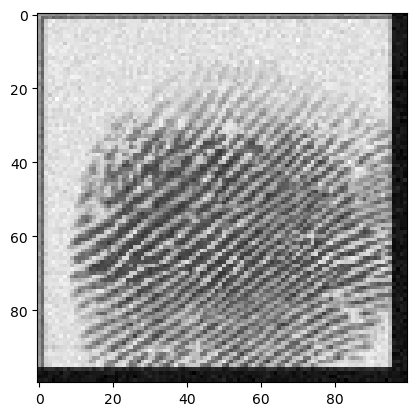

In [187]:
dl = DataLoader(authorized_dataset.data, batch_size = 1, shuffle=True)
img = next(iter(dl))

plt.imshow(img[0].squeeze(0).permute(1,2,0), cmap='gray')
plt.show()

In [172]:
class SiameseNet(nn.Module):
    def __init__(self, in_channels=1):
        """
        Args:
          in_channels - number of input channels (1 for grayscale images)

        Forward method takes two images and returnes their feature embeddings.
        We will be using contrastive loss for evaluation.
        """
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=1),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=1),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=4),
            nn.ReLU(inplace=True)
        )

        self.flatten = nn.Flatten()

        self.embed = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )

    def forward(self, image1, image2):
        x1, x2 = self.conv(image1), self.conv(image2)
        emb1, emb2 = self.flatten(x1), self.flatten(x2)
        emb1, emb2 = self.embed(emb1), self.embed(emb2)

        return emb1, emb2

In [173]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.05)

In [179]:
def train(net:SiameseNet, train_dl:DataLoader, valid_dl:DataLoader, comparison_dl:DataLoader, lr:float=5e-3, epochs:int=10, val_threshold:float=0.9, margin:float=1.3):        
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    loss_fn = ContrastiveLoss(margin=margin)
    epoch_progress = tqdm(list(range(epochs)))

    for e in epoch_progress:
        train_loss = 0.0
        net.train()
        try:
            for (X1, X2), y in train_dl:
                optimizer.zero_grad()
                X1, X2, y_true = X1.to(device), X2.to(device), y.to(device)
                output1, output2 = net(X1, X2)

                loss = loss_fn(output1, output2, y_true.float())
                loss.backward()
                optimizer.step()
                train_loss += loss.item() / len(y)

        except ValueError:
            for (X1, X2, y) in train_dl:
                optimizer.zero_grad()
                X1, X2, y_true = X1.to(device), X2.to(device), y.to(device)
                output1, output2 = net(X1, X2)

                loss = loss_fn(output1, output2, y_true.float())
                loss.backward()
                optimizer.step()
                train_loss += loss.item() / len(y)
        scheduler.step()

        net.eval()
        valid_loss = 0.0
        valid_acc = 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for (img1, img2), y_val in valid_dl:
                img1, img2 = img1.to(device), img2.to(device)
                out1, out2 = net(img1, img2)
                out1, out2 = out1.detach().cpu(), out2.detach().cpu()
                valid_loss += loss_fn(out1, out2, y_val.float()) / len(y)
                distance_val = F.pairwise_distance(out1, out2, keepdim=True)  # shape 100 x 1
                instance_pred = torch.where(distance_val <= val_threshold, 0, 1)  # where the distance is small, treat the otputs as of the same class - 0. Otherwise 1 - other class
                y_true.extend(y_val)
                y_pred.extend(instance_pred.tolist())

            if e == 0 or (e % 10 == 0) or e == epochs-1:
                plot_distances(net, comparison_dl)
                plot_distances(net, valid_dl, title='Database check for unseen augmented images', reverse=True)
                if e > 0:
                    check_authorization(net, fp_db, train_dataset.data[300:], transform=False, t=t, title='z-cut authorized users data') # all authorized users case, Zcut original images
                    check_authorization(net, fp_db, authorized_dataset.data, transform=False, t=t, title='noisy authorized users data')  # all authorized users case, once augmented
                    check_authorization(net, fp_db, impostors_dataset.data, transform=False, t=t)  # all impostors, clear data
                if e == epochs-1:
                    check_authorization(net, fp_db, train_dataset.data[300:], transform=True, t=t, title='z-cut noisy authorized users data') # all authorized users case, Zcut original images
                    check_authorization(net, fp_db, authorized_dataset.data, transform=True, t=t, title='double noisy authorized users data')  # all authorized users case, once augmented
                    check_authorization(net, fp_db, impostors_dataset.data, transform=True, t=t, title='noisy impostors data')  # all impostors, clear data

        valid_acc = accuracy_score(y_true, y_pred)
        epoch_progress.set_description(f'#Epoch no. {e}, train loss: {train_loss:.4f}, val loss: {valid_loss:.2f}, val accuracy: {valid_acc:.4f}')
        


def plot_distances(net:SiameseNet, dl:DataLoader, title:str='Original vs. Augmented', reverse:bool=False):
    for (X1, X2), y in dl:
        net.eval()
        output1, output2 = net(X1.to(device), X2.to(device))
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        if reverse:  # just so that the sequence of plots is the same
            X1, X2 = X2, X1
        fig, ax = plt.subplots(1,6, figsize=(15,3))
        for i in range(3):
            ax[2*i].imshow(X1.detach().cpu()[i].permute(1,2,0), cmap='gray')
            ax[2*i+1].imshow(X2.detach().cpu()[i].permute(1,2,0), cmap='gray')
            ax[2*i+1].set_title(f'distance: {distance[i].item():.4f}')
        plt.suptitle(title)
        plt.show()
        break


def check_authorization(net:SiameseNet, database_set:List, test_set:List, t:float=0.7, transform=True, title:str='all impostors data') -> float:
    N = len(test_set)
    test_dl = create_test_dl(database_set, test_set, transform=transform)
    net.eval()
    accuracy = 0.0
    
    with torch.no_grad():
        for (img1, img2), y in test_dl:
            img1, img2 = img1.to(device), img2.to(device)
            out1, out2 = net(img1, img2)
            out1, out2 = out1.detach().cpu(), out2.detach().cpu()
            distance = F.pairwise_distance(out1, out2, keepdim=True)  # shape 100 x 1
            instance_pred = torch.where(distance <= t, 0, 1)
            
            if (0 in instance_pred) and (0 in y):
                accuracy += 1 / N
            if sum(instance_pred) == len(y) and sum(y) == len(y):
                accuracy += 1 / N
    print(f'Authorization accuracy on {title}: {accuracy:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

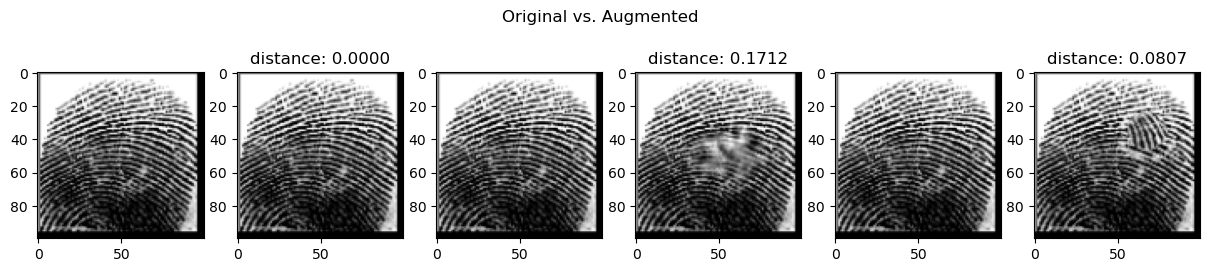

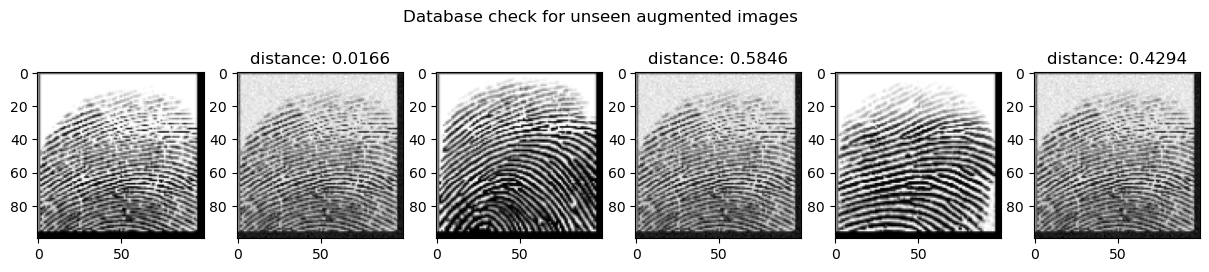

#Epoch no. 9, train loss: 0.0259, val loss: 0.73, val accuracy: 0.9931:  20%|██        | 10/50 [00:25<01:33,  2.34s/it]

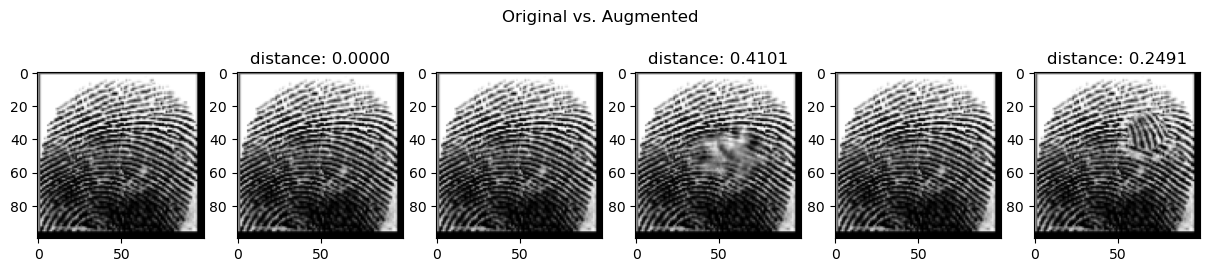

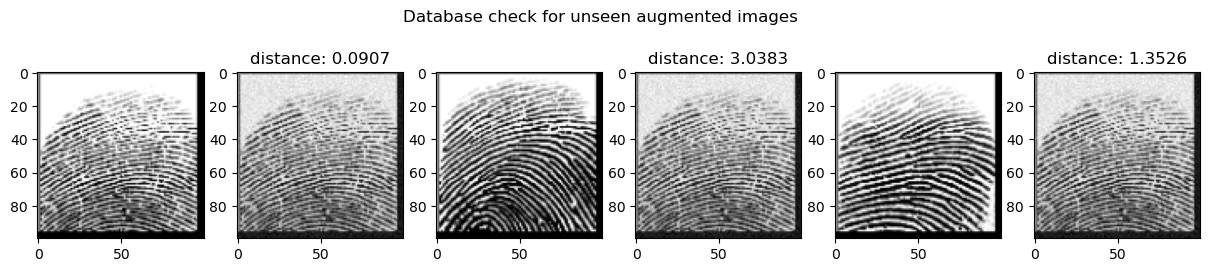

Authorization accuracy on z-cut authorized users data: 0.7800
Authorization accuracy on noisy authorized users data: 0.9900
Authorization accuracy on all impostors data: 0.4800


#Epoch no. 19, train loss: 0.0143, val loss: 0.78, val accuracy: 0.9964:  40%|████      | 20/50 [00:56<01:12,  2.41s/it]

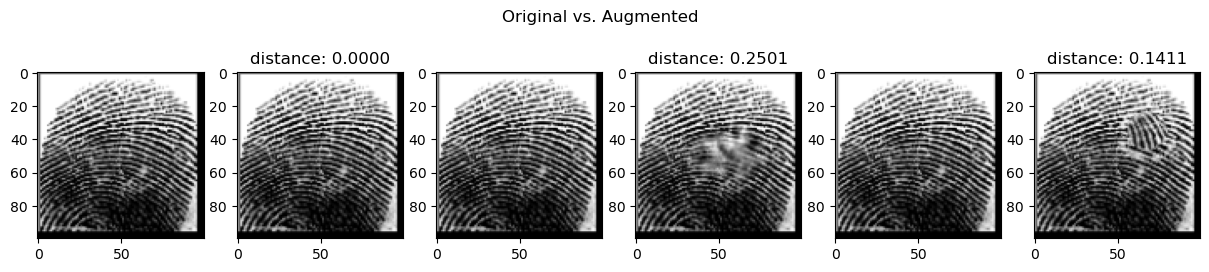

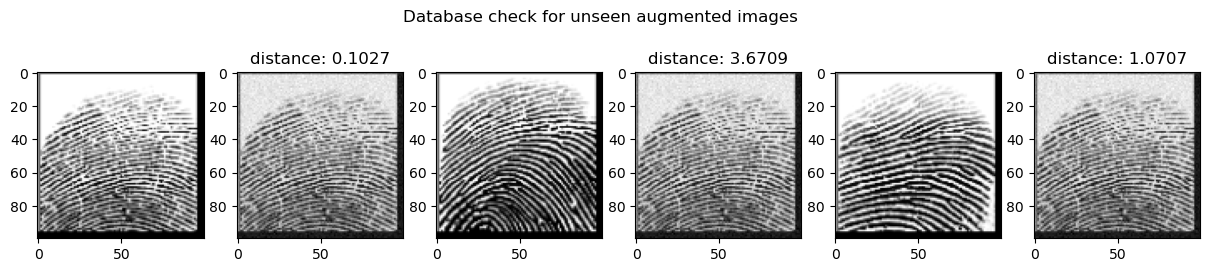

Authorization accuracy on z-cut authorized users data: 0.9000
Authorization accuracy on noisy authorized users data: 0.9900
Authorization accuracy on all impostors data: 0.6700


#Epoch no. 29, train loss: 0.0094, val loss: 0.87, val accuracy: 0.9977:  60%|██████    | 30/50 [01:27<00:48,  2.41s/it]

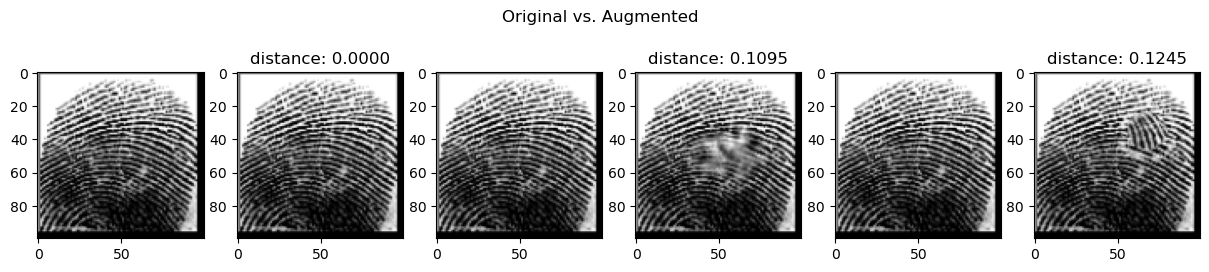

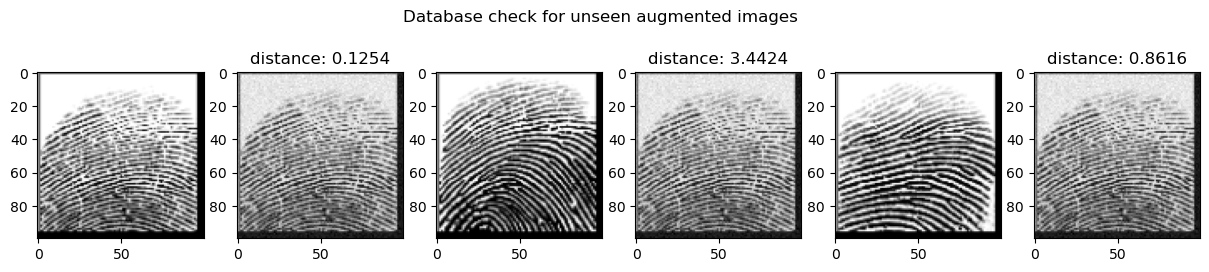

Authorization accuracy on z-cut authorized users data: 0.9700
Authorization accuracy on noisy authorized users data: 0.9600
Authorization accuracy on all impostors data: 0.8200


#Epoch no. 39, train loss: 0.0067, val loss: 0.95, val accuracy: 0.9979:  80%|████████  | 40/50 [01:57<00:23,  2.35s/it]

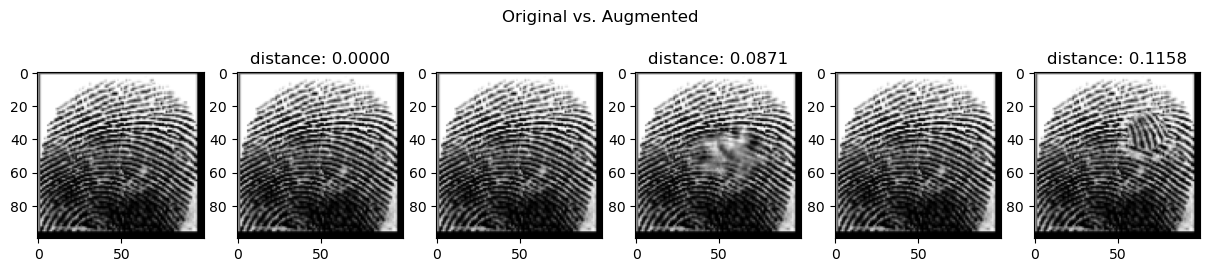

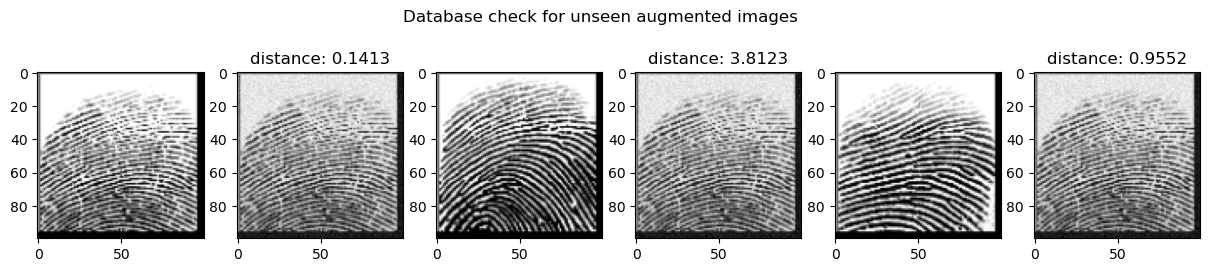

Authorization accuracy on z-cut authorized users data: 0.9600
Authorization accuracy on noisy authorized users data: 0.9500
Authorization accuracy on all impostors data: 0.8600


#Epoch no. 48, train loss: 0.0049, val loss: 1.04, val accuracy: 0.9977:  98%|█████████▊| 49/50 [02:25<00:02,  2.45s/it]

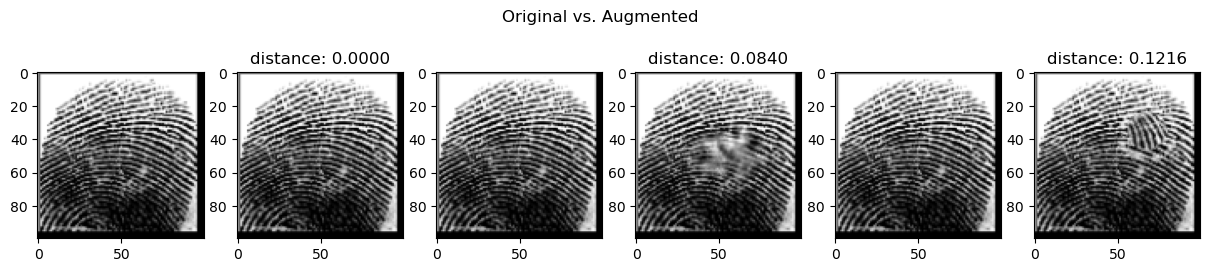

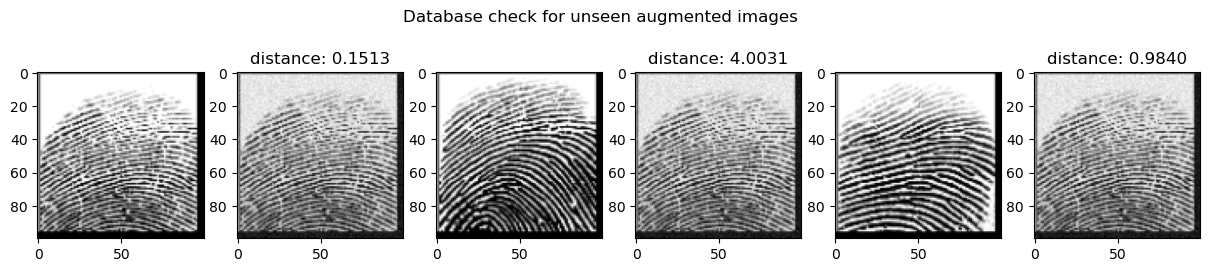

Authorization accuracy on z-cut authorized users data: 0.9700
Authorization accuracy on noisy authorized users data: 0.9300
Authorization accuracy on all impostors data: 0.8700
Authorization accuracy on z-cut noisy authorized users data: 0.6600
Authorization accuracy on double noisy authorized users data: 0.5000
Authorization accuracy on noisy impostors data: 0.8800


#Epoch no. 49, train loss: 0.0032, val loss: 1.06, val accuracy: 0.9977: 100%|██████████| 50/50 [03:10<00:00,  3.82s/it]


In [182]:
fp_db = train_dataset.data[:100]
t = 0.4
margin = 1.2

train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
valid_dl_authorized = create_test_dl(fp_db, authorized_dataset.data, transform=False) # unseen augmented images of authorized users
same_labels = [(X,y) for X,y in train_dataset.data if y == 110]
dl = create_test_dl(same_labels, [same_labels[0]])

net = SiameseNet()
net.apply(weights_init)

train(net=net, train_dl=train_dl, valid_dl=valid_dl_authorized, comparison_dl=dl, lr=1e-4, epochs=50, val_threshold=t, margin=margin)